In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped 'analysis' folder containing the 'functions' folder.
# e.g. 'Controlled\ Methane\ Release\ Stanford-Kairos\ Oct\ 2019/Elementa\ Submission/analysis'
folder_name = 'analysis/'
root_path = 'Controlled\ Methane\ Release\ Stanford-Kairos\ Oct\ 2019/Elementa\ Submission/'+folder_name

assert root_path is not None, "[!] Enter directory."

%cd drive/My\ Drive
%cp -r $root_path ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


# setup

In [174]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# auto-reload external Python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# ignore some warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# directory for storing graphs generated
graph_dir = folder_name+'graphs_manuscript/'

from datetime import date
today = date.today()
fdate = date.today().strftime('%m%d%Y')    # append the data today when exporting the graphs

# load data

In [0]:
data = pd.read_excel('analysis/Stanford-Kairos Controlled Release.xlsx',sheet_name='DATA',skiprows=1)
# data.info()

## Adjust methane release rate based on gas composition

Methane release rate is methane_vol% * total natural gas release rate

The average methane content from November 4- December 5 was 93.5% in the two BTU areas closest to Yolo/Sacramento where the gas was filled (downstream of the filling stations). The BTU areas are H09 and X01.
https://www.pge.com/pipeline/operations/gas_quality/index.page
BTU areas come from a map from PG&E's 2017 filing of FERC Form 2. The map is not in their most recent 2018 filing.

In [0]:
from analysis.functions.data_processing import convert_to_CH4_rate
CH4_vol_fraction = 0.935
data = convert_to_CH4_rate(data,CH4_vol_fraction)

## Convert from US/Imperial to Metric

In [0]:
from analysis.functions.data_processing import convert_to_metric

# CH4_density[kg/mcf] under 20 deg C and 1 atm
CH4_density = 1000/23.645/35.38 * 16.043       # kg/mcf
# (1000 scf/mcf) / (23.645 std m3/kmol) / (35.38 scf/std m3) * (16.043 kg/kmol) =  19.177 kg/mcf
# ref: molar weight of CH4 and number of moles in a standard cubic feet taken from the Gas Processes Association Handbook
# 1 scf is defined as a standard cubic feet at 14.696 psia = 1 atm and 15 degC
# see the handbook section 1 page 1-8
data = convert_to_metric(data,CH4_density)

## Exclude invalid data points
Based on sensitivity cases (base case presented in the manuscript) and wind speed data. Note that the ultrasonic anemometer was not available on 10/8/2019. Consequently, the Kairos quantification in (kg/h)/(m/s) cannot be multiplied with the concurrent wind speed measured by the ultrasonic anemometer on that day; hence reducing the number of valid data points if ultrasonic anemoemter is chosen.

In [0]:
from analysis.functions.data_processing import data_selection
WS_data = data_selection(data,'Base','WS_windGust_logged_mps')
sonic_data = data_selection(data,'Base','WS_windGust_logged_mps')

In [200]:
valid_data = data[(data.wrong_flight_altitude==0) & (data.multiple_release_points==0) & (data.closest_plume_not_fully_developed_WS==0)]
print ('%d valid releases (excluding wrong altitude, multiple release pionts, insufficient time for plume formaiton)' %valid_data.shape[0])

221 valid releases (excluding wrong altitude, multiple release pionts, insufficient time for plume formaiton)


In [201]:
negative_control_data = valid_data[valid_data.CH4_release_kgh==0]
print ('%d total number of valid negative control' %negative_control_data.shape[0])
print ('%d total number of valid nonnegative control' %(valid_data.shape[0]-negative_control_data.shape[0]))

21 total number of valid negative control
200 total number of valid nonnegative control


In [202]:
detected_nonnegative_control_data = valid_data[valid_data.CH4_release_kgh!=0].loc[~np.isnan(valid_data.closest_plume_quantification_kghmps)]
print ('%d detected nonnegative control, including some invalid data points due to extreme wind speeds or multiple release points' %detected_nonnegative_control_data.shape[0])

182 detected nonnegative control, including some invalid data points due to extreme wind speeds or multiple release points


In [203]:
threshold_partial_detection_design = 25  # kgh/mps
threshold_partial_detection_wind = 2   # mps
thres = threshold_partial_detection_design * threshold_partial_detection_wind   # kgh

valid_data_collected = data[data.wrong_flight_altitude==0]
print("of the %d data points excluding the 4 of wrong flight height, \n%d were negative controls\n%d nonzero releases below %d kgh were designed to find the detection threshold\n%d remaining large releases have \n%d within the range of %d and %d kg/h \n%d were over %d kg/h "
%(
  valid_data_collected.shape[0],
  valid_data_collected.loc[valid_data_collected.CH4_release_kgh==0].shape[0],
  valid_data_collected.loc[valid_data_collected.CH4_release_kgh>0].loc[valid_data_collected.CH4_release_kgh<=thres].shape[0],
  thres,
  valid_data_collected.loc[valid_data_collected.CH4_release_kgh>thres].shape[0],
  valid_data_collected.loc[valid_data_collected.CH4_release_kgh>thres].loc[valid_data_collected.CH4_release_kgh<=thres*10].shape[0],
  thres,
  thres*10,
  valid_data_collected.loc[valid_data_collected.CH4_release_kgh>thres*10].shape[0],
  thres*10
))

of the 230 data points excluding the 4 of wrong flight height, 
21 were negative controls
40 nonzero releases below 50 kgh were designed to find the detection threshold
169 remaining large releases have 
110 within the range of 50 and 500 kg/h 
59 were over 500 kg/h 


# detection threshold
Detection threshold in (kg/d)/(m/s) is determined with binned data

In [0]:
from analysis.functions.min_detection import detection_rate_by_bin
WS_data = data_selection(data,'Base','WS_windGust_logged_mps')
sonic_data = data_selection(data,'Base','sonic_windGust_mps')

## cup wind meter 

In [259]:
n_bins=5
threshold=25
detection_cup, detection_prob_cup=detection_rate_by_bin(WS_data,n_bins,threshold)
detection_prob_cup

,bin_median,detection_prob_mean,detection_prob_two_sigma_upper,detection_prob_two_sigma_lower,n_data_points,n_detected
0,2.5,0.000000,0.000000,0.000000,1,0
1,7.5,0.071429,0.137661,0.071429,14,1
2,12.5,0.666667,0.272166,0.272166,12,8
3,17.5,1.000000,0.000000,0.000000,5,5
4,22.5,1.000000,0.000000,0.000000,4,4


In [0]:
detection_prob = detection_prob_cup.copy()
detection = detection_cup.copy()

min_detected = detection.loc[detection.detected==True].release_rate_wind_normalized.min()
max_undetected = detection.loc[detection.detected==False].release_rate_wind_normalized.max()
partial_detection = detection.loc[detection.release_rate_wind_normalized>min_detected].loc[detection.release_rate_wind_normalized<max_undetected]

In [264]:
print("Kairos deteced all %d over %.1f kg/h(CH$_4$) per meter per second (mps) of wind and none of the %d nonzero releases below %.1f kg/h(CH$_4$)/mps"
      %(WS_data.loc[WS_data.CH4_release_kghmps>max_undetected].shape[0],
          max_undetected,
          detection[detection.release_rate_wind_normalized<min_detected].shape[0],
          min_detected))
print("%d of the %d releases were detected in the partial detection range" 
      %(partial_detection.loc[partial_detection.detected==True].shape[0],
        partial_detection.shape[0]))

Kairos deteced all 159 over 11.9 kg/h(CH$_4$) per meter per second (mps) of wind and none of the 12 nonzero releases below 8.3 kg/h(CH$_4$)/mps
7 of the 12 releases were detected in the partial detection range


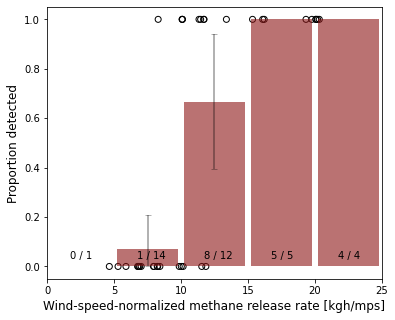

In [265]:
fig,ax = plt.subplots(figsize = [6,5])
for i in range(n_bins):
  ax.annotate('%d / %d' %(detection_prob.n_detected[i],detection_prob.n_data_points[i]),
              [detection_prob.bin_median[i]-0.8,0.03],fontsize=10)

# for plotting purpose, we don't want a small hypen indicating zero uncertainty interval
detection_prob.detection_prob_two_sigma_lower[detection_prob.detection_prob_two_sigma_lower==0]=np.nan  
detection_prob.detection_prob_two_sigma_upper[detection_prob.detection_prob_two_sigma_upper==0]=np.nan

# plot the bars and the detection points
ax.bar(detection_prob.bin_median,detection_prob.detection_prob_mean,
       yerr=[detection_prob.detection_prob_two_sigma_lower,detection_prob.detection_prob_two_sigma_upper],
       error_kw=dict(lw=2, capsize=3, capthick=1,alpha=0.3),
       width=threshold/n_bins-0.5,alpha=0.6,color='#8c1515',ecolor='black', capsize=2)
ax.scatter(detection.release_rate_wind_normalized,np.multiply(detection.detected,1),
           edgecolor="black",facecolors='none')
ax.set_xlabel('Wind-speed-normalized methane release rate [kgh/mps]',fontsize=12)
ax.set_ylabel('Proportion detected',fontsize=12)
ax.set_ylim([-0.05,1.05])
ax.set_xlim([0,threshold]) 
# ax.set_xticks([0,4,8,12,16,20,24])

# save fig
plt.savefig(graph_dir+'KairosDetectionThresholdCup'+fdate+'.pdf',format='pdf')

## ultrasonic anemometer

In [0]:
detection, detection_prob=detection_rate_by_bin(sonic_data,n_bins,threshold)
detection_prob

,bin_median,detection_prob_mean,detection_prob_two_sigma_upper,detection_prob_two_sigma_lower,n_data_points,n_detected
0,2.5,NaN,NaN,NaN,0,0
1,7.5,0.250000,0.433013,0.250000,4,1
2,12.5,0.846154,0.153846,0.200137,13,11
3,17.5,1.000000,0.000000,0.000000,5,5
4,22.5,1.000000,0.000000,0.000000,3,3


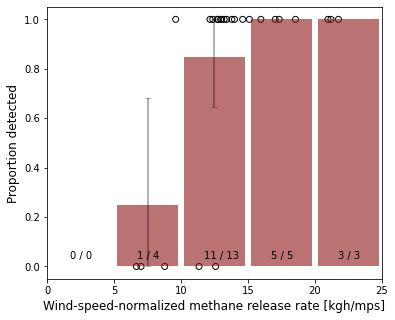

In [0]:
fig,ax = plt.subplots(figsize = [6,5])
for i in range(n_bins):
  ax.annotate('%d / %d' %(detection_prob.n_detected[i],detection_prob.n_data_points[i]),
              [detection_prob.bin_median[i]-0.8,0.03],fontsize=10)

# for plotting purpose, we don't want a small hypen indicating zero uncertainty interval
detection_prob.detection_prob_two_sigma_lower[detection_prob.detection_prob_two_sigma_lower==0]=np.nan  
detection_prob.detection_prob_two_sigma_upper[detection_prob.detection_prob_two_sigma_upper==0]=np.nan

# plot the bars and the detection points
ax.bar(detection_prob.bin_median,detection_prob.detection_prob_mean,
       yerr=[detection_prob.detection_prob_two_sigma_lower,detection_prob.detection_prob_two_sigma_upper],
       error_kw=dict(lw=2, capsize=3, capthick=1,alpha=0.3),
       width=threshold/n_bins-0.5,alpha=0.6,color='#8c1515',ecolor='black', capsize=2)
ax.scatter(detection.release_rate_wind_normalized,np.multiply(detection.detected,1),
           edgecolor="black",facecolors='none')
ax.set_xlabel('Wind-speed-normalized methane release rate [kgh/mps]',fontsize=12)
ax.set_ylabel('Proportion detected',fontsize=12)
ax.set_ylim([-0.05,1.05])
ax.set_xlim([0,threshold]) 
# ax.set_xticks([0,4,8,12,16,20,24])

# save fig
plt.savefig(graph_dir+'KairosDetectionThresholdUltrasonic'+fdate+'.pdf',format='pdf')

# parity chart

## Ordinary Linear Regression

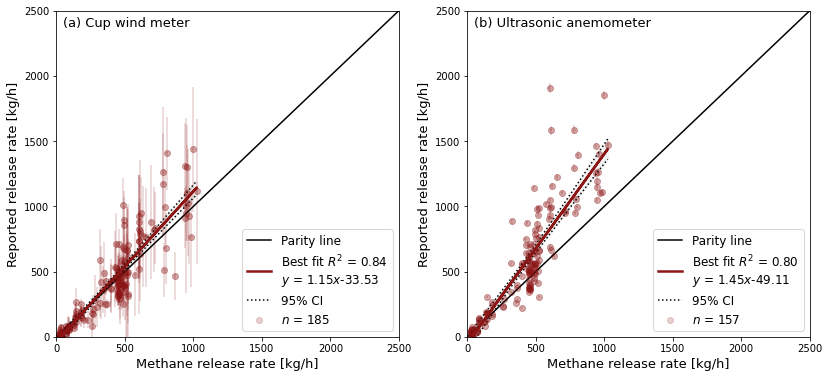

In [209]:
from analysis.functions.parity import linreg_results

################################ INPUTS ######################################
plot_interval = ['confidence']     # choose from ['confidence','prediction']
case = 'Base'      # choose from ['Loose','Base','Strict'] case-sensitive

################################ Figure setup #################################
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[13.5,6])
ax1.annotate('(a) Cup wind meter', [50,2380],fontsize=13)
ax2.annotate('(b) Ultrasonic anemometer', [50,2380],fontsize=13)
ax1.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax1.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax2.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax2.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax1.set_xlim([0,2500]),ax1.set_ylim([0,2500]),ax2.set_xlim([0,2500]),ax2.set_ylim([0,2500])

x_lim = np.array([0,3000])
y_lim = np.array([0,3000])
ax1.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax2.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line

################################# cup wind meter ####################

plot_data = data_selection(data,case,'WS_windGust_logged_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,pearson_corr,slope,intercept,r_value,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results(x,y)

ax1.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax1.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax1.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$%0.2f' % (r_value**2,slope,intercept))
if 'confidence' in plot_interval:
    ax1.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax1.plot(np.sort(x),lower_CI,':',color='black')
    ax1.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax1.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax1.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax1.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax1.legend(loc="lower right",fontsize=12)

################################# ultrasonic anemometer ####################

plot_data = data_selection(data,case,'sonic_windGust_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,pearson_corr,slope,intercept,r_value,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results(x,y)

ax2.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax2.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax2.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$%0.2f' % (r_value**2,slope,intercept))
if 'confidence' in plot_interval:
    ax2.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax2.plot(np.sort(x),lower_CI,':',color='black')
    ax2.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax2.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax2.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax2.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax2.legend(loc="lower right",fontsize=12)

# save fig
plt.savefig(graph_dir+'KairosDetectionParity'+fdate+'.pdf',format='pdf')

## force zero intercept

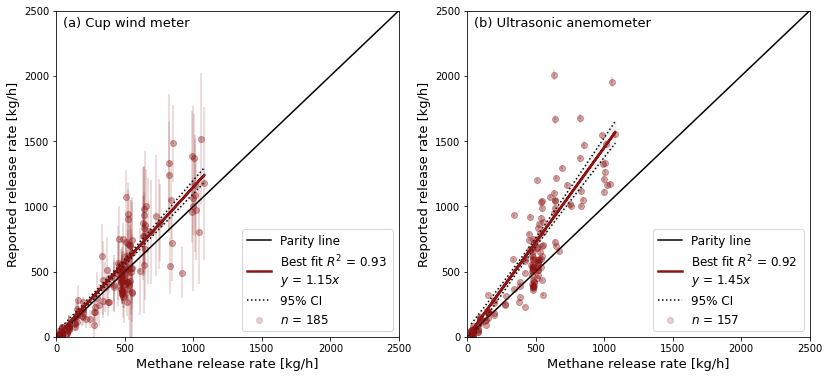

In [0]:
from analysis.functions.parity import linreg_results_no_intercept

################################ INPUTS ######################################
plot_interval = ['confidence']     # choose from ['confidence','prediction']
case = 'Base'      # choose from ['Loose','Base','Strict'] case-sensitive

################################ Figure setup #################################
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[13.5,6])
ax1.annotate('(a) Cup wind meter', [50,2380],fontsize=13)
ax2.annotate('(b) Ultrasonic anemometer', [50,2380],fontsize=13)
ax1.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax1.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax2.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax2.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax1.set_xlim([0,2500]),ax1.set_ylim([0,2500]),ax2.set_xlim([0,2500]),ax2.set_ylim([0,2500])

x_lim = np.array([0,3000])
y_lim = np.array([0,3000])
ax1.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax2.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line

################################# cup wind meter ####################

plot_data = data_selection(data,case,'WS_windGust_logged_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

ax1.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax1.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax1.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax1.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax1.plot(np.sort(x),lower_CI,':',color='black')
    ax1.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax1.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax1.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax1.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax1.legend(loc="lower right",fontsize=12)

################################# ultrasonic anemometer ####################

plot_data = data_selection(data,case,'sonic_windGust_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

ax2.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax2.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax2.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax2.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax2.plot(np.sort(x),lower_CI,':',color='black')
    ax2.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax2.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax2.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax2.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax2.legend(loc="lower right",fontsize=12)

# save fig
plt.savefig(graph_dir+'KairosDetectionParityZeroIntercept'+fdate+'.pdf',format='pdf')

# field efficacy

In [0]:
# load Omara data 
Omara_data = pd.read_excel('analysis/Omara_et_Al_2018_studyData.xlsx',sheet_name='StudyData',skiprows=34)
features_to_keep = ['Region/Study','Mean absolute CH4  Emissions (kg/h)']
Omara_data = Omara_data[features_to_keep]

In [289]:
# compute wind normalized Omara emission
wind = 2 # m/s
Omara_data['wind_normalized_CH4_emission_kghmps'] = Omara_data['Mean absolute CH4  Emissions (kg/h)']/wind
Omara_data.sample(5)

,Region/Study,Mean absolute CH4 Emissions (kg/h),wind_normalized_CH4_emission_kghmps
848,Pinedale - Brantley et al,1.752042,0.876021
865,Pinedale - Brantley et al,0.292505,0.146252
573,DJB - Brantley et al,2.396489,1.198245
350,Barnett - Lan et al,1.310000,0.655000
172,Barnett - ERG,0.017700,0.008850


In [0]:
# load Kairos detection probability
detection_prob = detection_prob_cup.copy()

detection_bin = detection_prob.bin_median[0]*2

In [291]:
# find detection rate of each Omara emission
n_sites = Omara_data.shape[0]
Kairos_detection_rate = np.zeros(n_sites)
n_Omara_data_points = np.zeros(detection_prob.shape[0]).astype('int')
bin_Omara_emission = np.zeros(detection_prob.shape[0])
bin_Omara_emission_detected = np.zeros(detection_prob.shape[0])
for i in range(n_sites):
  WN_emission = Omara_data.wind_normalized_CH4_emission_kghmps[i]
  detection_rate = 1.0        # initialize
  for j in range(detection_prob.shape[0]):
    # assign detection rate if falling in the bin
    if (WN_emission >= detection_bin*j) & (WN_emission < detection_bin*(j+1)):
      detection_rate = detection_prob.detection_prob_mean[j]
      n_Omara_data_points[j] += 1    # record the data point in the detection bin
      bin_Omara_emission[j] += WN_emission*wind
      bin_Omara_emission_detected[j] += WN_emission*wind*detection_rate
  # store the detection rate
  Kairos_detection_rate[i] = detection_rate

detection_prob['n_Omara_data_points'] = n_Omara_data_points
detection_prob['bin_Omara_emission_kgh'] = bin_Omara_emission
detection_prob['bin_Omara_emission_detected_kgh'] = bin_Omara_emission_detected
Omara_data['Kairos_detection_rate'] = Kairos_detection_rate
Omara_data['Kairos_detected_wind_normalized_CH4_emission_kghmps'] = Kairos_detection_rate*Omara_data.wind_normalized_CH4_emission_kghmps
detection_prob = detection_prob.append(pd.DataFrame({'bin_median':['>'+str(detection_bin*(j+1))],
                                                     'detection_prob_mean':1,
                                                     'n_Omara_data_points':n_sites-detection_prob.n_Omara_data_points.sum(),
                                                     'bin_Omara_emission_kgh':Omara_data[Omara_data.wind_normalized_CH4_emission_kghmps>=detection_bin*j].wind_normalized_CH4_emission_kghmps.sum()*wind,
                                                     'bin_Omara_emission_detected_kgh':Omara_data[Omara_data.wind_normalized_CH4_emission_kghmps>=detection_bin*j].wind_normalized_CH4_emission_kghmps.sum()*wind*1}))
detection_prob[['bin_median','detection_prob_mean','n_Omara_data_points','bin_Omara_emission_kgh','bin_Omara_emission_detected_kgh']]

,bin_median,detection_prob_mean,n_Omara_data_points,bin_Omara_emission_kgh,bin_Omara_emission_detected_kgh
0,2.5,0.000000,930,1516.949222,0.000000
1,7.5,0.071429,47,632.831363,45.202240
2,12.5,0.666667,8,205.175340,136.783560
3,17.5,1.000000,3,101.133563,101.133563
4,22.5,1.000000,6,268.974303,268.974303
0,>25.0,1.000000,15,1872.084589,1872.084589


In [292]:
print('at %.1f mps wind\ntotal Omara emission is %d kg/h    \ndetected emission is %d kg/h    \nfraction detected is %.3f   \n%d sites above the full detection threshold contribute %.3f' 
      %(wind,
        detection_prob.bin_Omara_emission_kgh.sum(),
        detection_prob.bin_Omara_emission_detected_kgh.sum(),
        detection_prob.bin_Omara_emission_detected_kgh.sum() / detection_prob.bin_Omara_emission_kgh.sum(),
        detection_prob[detection_prob.detection_prob_mean==1].n_Omara_data_points.sum(),
        detection_prob[detection_prob.detection_prob_mean==1].bin_Omara_emission_detected_kgh.sum() / detection_prob.bin_Omara_emission_kgh.sum()
        ))

at 2.0 mps wind
total Omara emission is 4597 kg/h    
detected emission is 2424 kg/h    
fraction detected is 0.527   
24 sites above the full detection threshold contribute 0.488


# save functions and graphs
Run the following cells to save graphs and functions. Even if the main ipynb is saved, the changes made to the functions and the graphs generated will be lost if these cells are not executed.

In [0]:
import os
folder_to_save = 'drive/My Drive/Controlled Methane Release Stanford-Kairos Oct 2019/Elementa Submission/analysis/'

In [0]:
# functions
files_to_save = ['functions/data_processing.py','functions/min_detection.py']

for files in files_to_save:
  with open(os.path.join(folder_to_save+files), 'w') as f:
    f.write(folder_to_save.join(open(folder_to_save+files).readlines()))

In [0]:
# graphs
files_to_save = ['graphs_manuscript/'+'KairosDetectionThresholdCup'+fdate+'.pdf',
                 'graphs_manuscript/'+'KairosDetectionThresholdUltrasonic'+fdate+'.pdf']

for files in files_to_save:
  with open(os.path.join(folder_to_save+files), 'w') as f:
    f.write(folder_to_save.join(open(folder_to_save+files).readlines()))